In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import torchvision.utils as utils
from sklearn.preprocessing import MinMaxScaler

In [2]:
df_data = pd.read_csv('data/Producto-interno-bruto-trimestral.csv', usecols=['GDP', 'Time'])

In [3]:
def get_date(epoch_time):
    epoch_time /= 1000
    return time.strftime('%Y-%m-%d', time.gmtime(epoch_time))

In [4]:
def get_labels(df):
    labels = []
    indxs = []
    for i in range(len(df['Time'])):
        if (i%4==0):
            label_str = df['Time'][i][:4]
            labels.append(label_str)
            indxs.append(i)
    return labels, indxs

In [5]:
def memory_cell(ordered_set, time_step):
    features, targets = [], []
    for indx in range(len(ordered_set)-time_step):
        indx_feature = ordered_set[indx:indx+time_step]
        indx_target = ordered_set[indx+1:indx+time_step+1]
        features.append(indx_feature)
        targets.append(indx_target)
    features = np.array(features)
    targets = np.array(targets)
    return torch.tensor(features, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

## Preprocessing data

In [6]:
df_data['Time'] = df_data['Time'].transform(lambda x: get_date(x))
df_data['GDP'] = df_data['GDP'].transform(lambda x: x/1000000000)
df_data = df_data.reindex(columns=['Time','GDP'])

In [7]:
train_size = round(0.7*df_data.shape[0])
train_set = df_data.iloc[:train_size-1] 
test_set = df_data.iloc[train_size:] 

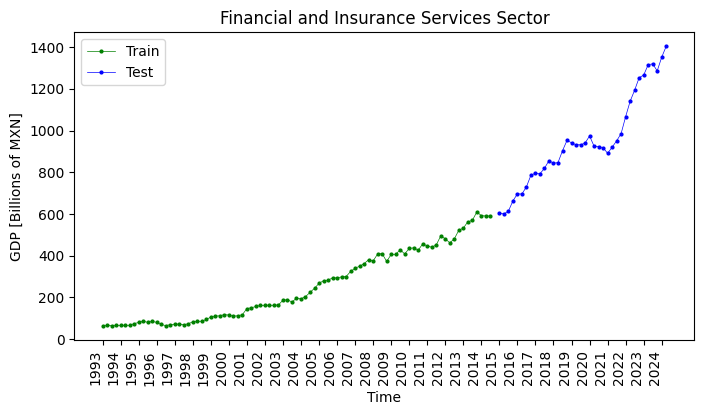

In [8]:
plt.figure(figsize=(8,4))
plt.plot(train_set['GDP'], label='Train', marker='.', markersize='4', linewidth='0.5', color='green')
plt.plot(test_set['GDP'], label='Test', marker='.', markersize='4', linewidth='0.5', color='blue')
plt.title('Financial and Insurance Services Sector')
plt.ylabel('GDP [Billions of MXN]')
labels, indxs = get_labels(df_data)
plt.xticks(indxs, labels, rotation=90, ha="right")
plt.xlabel('Time')
plt.legend() 
plt.show()

In [9]:
sc = MinMaxScaler(feature_range=(-1, 1))
train_np = np.array(train_set['GDP'])
train_np = train_np.reshape(-1, 1)
train_set_scaled = sc.fit_transform(train_np)
features_train, targets_train = memory_cell(train_set_scaled, time_step=3)
train_set_tensor = torch.utils.data.TensorDataset(features_train, targets_train)

In [10]:
test_np = np.array(test_set['GDP'])
test_np = test_np.reshape(-1, 1)
test_set_scaled = sc.fit_transform(test_np)
features_test, targets_test = memory_cell(test_set_scaled, time_step=3)
test_set_tensor = torch.utils.data.TensorDataset(features_test, targets_test)

## LSTM 

In [11]:
if torch.cuda.is_available(): 
    dev = "cuda:0"
else: 
    dev = "cpu"

In [12]:
class LSTM(nn.Module):
    def __init__(self, train_set, test_set):
        self.batch_size = 64
        self.train_loader = torch.utils.data.DataLoader(dataset=train_set_tensor,
                                                        batch_size=self.batch_size,
                                                        shuffle=True)        
        self.test_loader = torch.utils.data.DataLoader(dataset=test_set_tensor,
                                                        batch_size=self.batch_size,
                                                        shuffle=False)        
        super(LSTM, self).__init__()      
        self.lstm_layer_1 = nn.LSTM(input_size=1, hidden_size=64, batch_first=True)
        self.fully_layer_2 = nn.Sequential(nn.Linear(64, 32))
        self.fully_layer_3 = nn.Sequential(nn.Linear(32, 1))

    def forward(self, input_seq):
        out, _ = self.lstm_layer_1(input_seq)
        out = self.fully_layer_2(out)
        out = self.fully_layer_3(out)
        return out

In [13]:
class Learning_class():
    def __init__(self, model):
        self.epochs = 50
        self.device = torch.device(dev)
        self.model = model.to(self.device)
        self.loss_func = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.train_loss_hist = []
        self.test_loss_hist = []
        self.history = []

    def train_model(self):
        for epoch in range(self.epochs):
            train_loss = 0.0
            self.model.train()
            for scaled_batch, target_batch in self.model.train_loader:
                scaled_batch = scaled_batch.to(self.device)
                target_batch = target_batch.to(self.device)
                forecast_batch = self.model(scaled_batch)
                loss = self.loss_func(forecast_batch, target_batch)
                with torch.no_grad():
                    train_loss += loss.item()
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            train_loss /= len(self.model.train_loader)
            
            test_loss = 0.0
            self.model.eval()
            with torch.inference_mode():
                for scaled_batch, target_batch in self.model.test_loader:
                    scaled_batch = scaled_batch.to(self.device)
                    target_batch = target_batch.to(self.device)
                    forecast_batch = self.model(scaled_batch)
                    loss = self.loss_func(forecast_batch, target_batch)
                    with torch.no_grad():
                        test_loss += loss.item()
                test_loss /= len(self.model.test_loader)
            
            print(f"Epoch: {epoch+1} Train loss: {train_loss: .5f} Test loss: {test_loss: .5f}")
            self.train_loss_hist.append(train_loss)

        return self.model, self.train_loss_hist

In [14]:
model = LSTM(train_set_scaled, test_set_scaled)
learning_model = Learning_class(model)
trained_model, history = learning_model.train_model()

Epoch: 1 Train loss:  0.40869 Test loss:  0.23592
Epoch: 2 Train loss:  0.36402 Test loss:  0.23288
Epoch: 3 Train loss:  0.38321 Test loss:  0.22988
Epoch: 4 Train loss:  0.33405 Test loss:  0.22714
Epoch: 5 Train loss:  0.31503 Test loss:  0.22483
Epoch: 6 Train loss:  0.31217 Test loss:  0.22274
Epoch: 7 Train loss:  0.32968 Test loss:  0.22082
Epoch: 8 Train loss:  0.34001 Test loss:  0.21939
Epoch: 9 Train loss:  0.27130 Test loss:  0.21766
Epoch: 10 Train loss:  0.28354 Test loss:  0.21492
Epoch: 11 Train loss:  0.28746 Test loss:  0.21044
Epoch: 12 Train loss:  0.24085 Test loss:  0.20337
Epoch: 13 Train loss:  0.22721 Test loss:  0.19371
Epoch: 14 Train loss:  0.20280 Test loss:  0.18098
Epoch: 15 Train loss:  0.20422 Test loss:  0.16543
Epoch: 16 Train loss:  0.18733 Test loss:  0.14830
Epoch: 17 Train loss:  0.17075 Test loss:  0.13036
Epoch: 18 Train loss:  0.14698 Test loss:  0.11319
Epoch: 19 Train loss:  0.12018 Test loss:  0.09772
Epoch: 20 Train loss:  0.11116 Test loss